In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction, skipped_timeseries_formatting
from dendropy import TreeList, Tree
import time
import statsmodels.api as sm
from scipy.stats import pearsonr, gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure 5: Mobility changes in the US.
Using safegraph mobility data, we estimate how mobility changed over the course of the pandemic.

Previously, we estimated the global efficiency of a mobility network for each week between January 2019 and July 2021. In this mobility network, counties in the US are nodes, which are connected by the estimated number of people travelling between them in the given week. We calculate the mean number of travelers between each location as the global efficiency of the network, which takes into consideration the multiple pathways connecting locations. Additionally, we calculate the mean distance traveled between locations, in a straightforward manner. This takes a bit of time to calculate, so we do it in another longer-running script.

Here we load the results of that analysis.

In [2]:
mob = pd.read_csv( "../data/mobility_efficiency.csv", parse_dates=["date"] )
mob["week"] = mob["date"].apply( lambda x: Week.fromdate( x ).startdate() )
mob.head()

,date,efficiency,distance,county_distance,week
0,2019-01-07,227.358491,84.915639,282.054801,2019-01-06
1,2019-01-14,246.008601,89.790370,292.885919,2019-01-13
2,2019-01-21,238.265215,87.271661,281.868050,2019-01-20
3,2019-01-28,210.548791,70.489740,248.932353,2019-01-27
4,2019-02-04,221.949561,79.781386,267.338114,2019-02-03


Both the frequency and distance of travel vary quite drastically from week to week, which is expected. Therefore, we smooth the metrics using LOESS smoothening. We additionally estimated confidence intervals by bootstrapping weeks 1000 times.

In [51]:
ef_bootstrap = list()
dist_bootstrap = list()
for i in range(1000):
    boot = mob.sample( frac=1, replace=True )
    smoothed = pd.DataFrame( sm.nonparametric.lowess( boot["efficiency"], mdates.date2num( boot["date" ] ), frac=0.2 ), columns=["date", "value"] )
    dist_smoothed = pd.DataFrame( sm.nonparametric.lowess( boot["distance"], mdates.date2num( boot["date" ] ), frac=0.2 ), columns=["date", "value"] )
    ef_bootstrap.append( smoothed )
    dist_bootstrap.append( dist_smoothed )
    
ef = pd.concat( ef_bootstrap )
ef = ef.groupby( "date" ).describe( percentiles=[0.025,0.5, 0.975] )
ef = ef.droplevel( 0, axis=1 ).reset_index()
ef["date"] = mdates.num2date( ef["date"] )
ef["date"] = ef["date"].dt.normalize()
ef["counter_median"] = ef["50%"]
ef.loc[ef["date"] > "2020-01-05","counter_median"] = ef["50%"].shift( 52 )
ef.loc[ef["date"] > "2021-01-01","counter_median"] = ef["50%"].shift( 104 )
ef["counter_upper"] = ef["97.5%"]
ef.loc[ef["date"] > "2020-01-05","counter_upper"] = ef["97.5%"].shift( 52 )
ef.loc[ef["date"] > "2021-01-01","counter_upper"] = ef["97.5%"].shift( 104 )
ef["counter_lower"] = ef["2.5%"]
ef.loc[ef["date"] > "2020-01-05","counter_lower"] = ef["2.5%"].shift( 52 )
ef.loc[ef["date"] > "2021-01-01","counter_lower"] = ef["2.5%"].shift( 104 )
#entry.loc[entry["index"] > "2021-01-07","counter_travelers"] = entry["corrected_visitor_count"].shift( 730 )
ef.head()

dist = pd.concat( dist_bootstrap )
dist = dist.groupby( "date" ).describe( percentiles=[0.025,0.5, 0.975] )
dist = dist.droplevel( 0, axis=1 ).reset_index()
dist["date"] = mdates.num2date( dist["date"] )
dist["date"] = dist["date"].dt.normalize()
dist["counter_median"] = dist["50%"]
dist.loc[dist["date"] > "2020-01-05","counter_median"] = dist["50%"].shift( 52 )
dist.loc[dist["date"] > "2021-01-01","counter_median"] = dist["50%"].shift( 104 )
dist["counter_upper"] = dist["97.5%"]
dist.loc[dist["date"] > "2020-01-05","counter_upper"] = dist["97.5%"].shift( 52 )
dist.loc[dist["date"] > "2021-01-01","counter_upper"] = dist["97.5%"].shift( 104 )
dist["counter_lower"] = dist["2.5%"]
dist.loc[dist["date"] > "2020-01-05","counter_lower"] = dist["2.5%"].shift( 52 )
dist.loc[dist["date"] > "2021-01-01","counter_lower"] = dist["2.5%"].shift( 104 )

We plot how the frequency and distance of travel changed over time. To determine how travel changed relative to pre-pandemic levels, we overlay the data from 2019 through 2021.

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


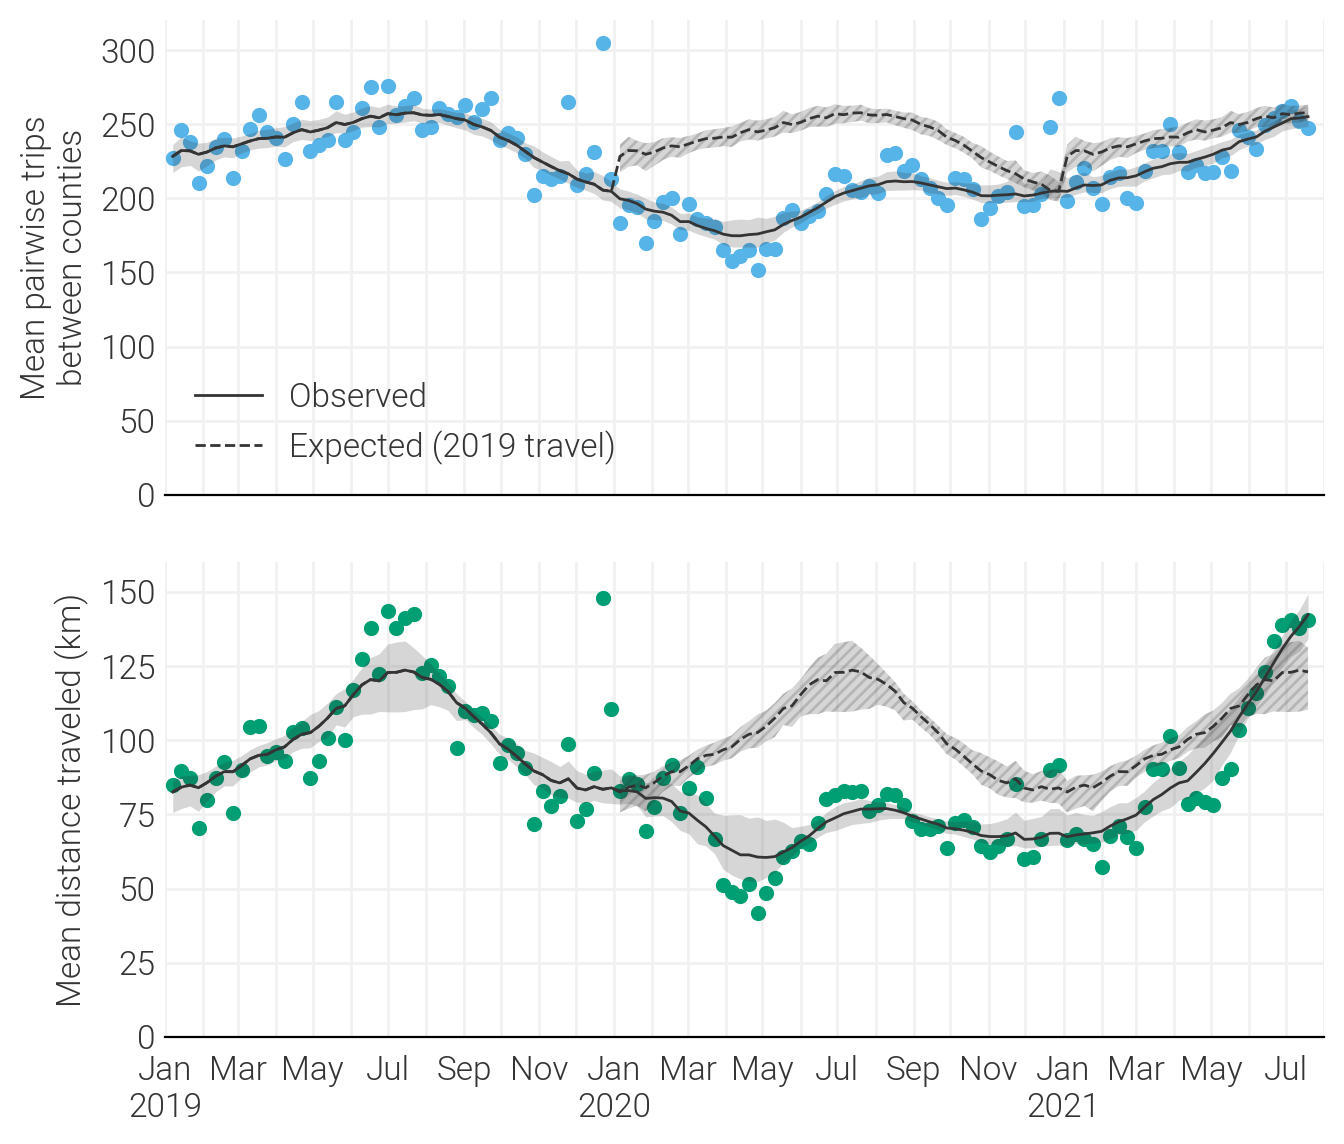

In [66]:
fig, ax = plt.subplots( dpi=200, figsize=(7,6), nrows=2, sharex=True)
ax[0].scatter( mob["date"], mob["efficiency"], color="#56B4E9", s=20, zorder=5 )
ax[0].plot( "date", "50%", data=ef, color=COLOR, linewidth=1, zorder=10, label="Observed" )
ax[0].fill_between( "date", "2.5%", "97.5%", data=ef, color=COLOR, alpha=0.2, linewidth=False, zorder=9)
ax[0].plot( "date", "counter_median", data=ef, color=COLOR, linestyle="dashed", linewidth=1, zorder=10, label="Expected (2019 travel)" )
ax[0].fill_between( "date", "counter_lower", "counter_upper", data=ef.loc[ef["date"] > "2020-01-05"], color=COLOR, alpha=0.2, linewidth=False, zorder=8, hatch="//////" )
basic_formatting( ax[0], spines=["bottom"], which="both", ylabel="Mean pairwise trips\nbetween counties", xlims=( pd.to_datetime( "2019-01-01" ), pd.to_datetime( "2021-08-01" ) ), ylims=(0, mob["efficiency"].max()*1.05), ysize=12, xsize=12 )
skipped_timeseries_formatting(ax[0])
ax[0].label_outer()

ax[1].scatter( mob["date"], mob["distance"], color="#009E73", s=20, zorder=5 )
ax[1].plot( "date", "50%", data=dist, color=COLOR, linewidth=1, zorder=10 )
ax[1].fill_between( "date", "2.5%", "97.5%", data=dist, color=COLOR, alpha=0.2, linewidth=False, zorder=9)
ax[1].plot( "date", "counter_median", data=dist, color=COLOR, linestyle="dashed", linewidth=1, zorder=10 )
ax[1].fill_between( "date", "counter_lower", "counter_upper", data=dist.loc[dist["date"] > "2020-01-05"], color=COLOR, alpha=0.2, linewidth=False, zorder=8, hatch="//////" )
basic_formatting( ax[1], spines=["bottom"], which="both", ylabel="Mean distance traveled (km)", xlims=( pd.to_datetime( "2019-01-01" ), pd.to_datetime( "2021-08-01" ) ), ylims=[0,160], ysize=12, xsize=12 )
skipped_timeseries_formatting(ax[1])
ax[1].tick_params( axis="x", pad=3 )

ax[0].legend( loc="lower left", frameon=False, fontsize=12 )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureX_mobility-network-efficiency-distance.pdf" )
plt.show()

We additionally calculated the correlation between mobility and phylogenetic similarity for each location included the the phylogenetic similarity analysis (Locations with >1000 genomes, all else collapsed into parent administration level).

In [32]:
corr = pd.read_csv( "../data/mobility_phylosor_correlation.csv" )
corr.head()

,siteA,siteB,corr,count
0,Alabama_USA,Alameda_CA,0.647942,10
1,Alabama_USA,Alaska_USA,0.549273,10
2,Alabama_USA,Albany_NY,0.869011,3
3,Alabama_USA,Arizona_USA,0.636447,10
4,Alabama_USA,Arkansas_USA,0.457488,7


We plot the distribution in Pearson correlation coefficients for all locations, and label the percentage of locations with a positive correlation.

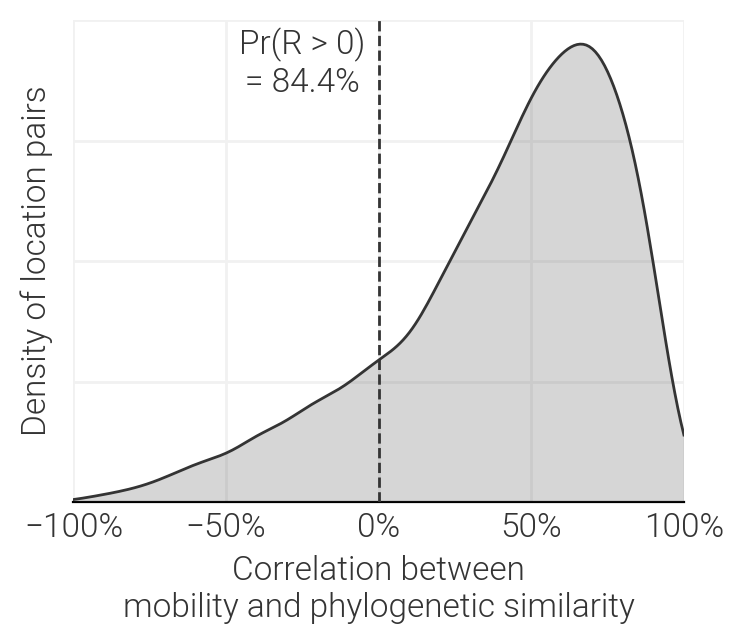

In [58]:
fig, ax = plt.subplots( dpi=200, figsize=(4,3.5) )

data = corr.loc[corr["count"]>4,"corr"]
x_grid = np.linspace( -1, 1, 201 )
kde = gaussian_kde( data )
y_grid = kde.evaluate( x_grid )
y_grid = y_grid / y_grid.max() * 0.95

pr_positive = (corr.loc[corr["count"]>4,"corr"]>0).sum() / corr.loc[corr["count"]>4].shape[0]

ax.plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax.fill_between(x_grid,[y for y in y_grid], facecolor=COLOR, edgecolor='none', alpha=0.2, zorder=100)

#eii_difference["log_diff"].plot( kind="kde", ax=ax )
ax.axvline( 0, color=COLOR, linestyle="dashed", linewidth=1, zorder=102 )
#ax.annotate( f"Mexico\n({mex_log_diff:.1%} reduction)", (mex_log_diff, ax.get_ylim()[1]), (0,2), textcoords="offset points", ha="center", size=10, color="#009E73" )
ax.text( -0.25, 0.85, f"Pr(R > 0)\n= {pr_positive:.1%}", fontsize=12, ha="center" )

ax.set_ylim( 0 )
basic_formatting( ax, which="both", ylabel="Density of location pairs", xlabel="Correlation between\nmobility and phylogenetic similarity", xlims=(-1, 1), ylims=(0,1), xsize=12, ysize=12 )
ax.xaxis.set_major_formatter( PercentFormatter(1) )
ax.tick_params( axis="x", rotation=0 )
ax.set_yticks( [0,0.25,0.5,0.75,1])
ax.set_yticklabels( [] )
ax.set_facecolor( "w" )
plt.tight_layout()
plt.show()

We next determine whether changes in the frequency and distance of travel are explained by the strigency of US policy against COVID-19. We load the stringency index from Oxford's policy database.

In [34]:
stringency = pd.read_csv( "https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=["date"], usecols=["location", "date", "stringency_index"] )
stringency = stringency.loc[stringency["location"]=="United States"]
stringency = stringency.drop( columns=["location"] )
stringency["week"] = stringency["date"].apply( lambda x: Week.fromdate( x ).startdate() )
stringency = stringency.groupby( "week" )["stringency_index"].agg( ["mean", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975 )] )
stringency.columns = ["stringency", "stringency_lower", "stringency_upper"]
#stringency.index = pd.to_datetime( stringency.index )
stringency.head()

,stringency,stringency_lower,stringency_upper
week,,,
2019-12-29,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0
2020-01-12,0.0,0.0,0.0
2020-01-19,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0


We merge stringency with mobility metrics.

In [35]:
test = mob.merge( stringency, left_on="week", right_index=True, how="left" )
test.head()

,date,efficiency,distance,county_distance,week,stringency,stringency_lower,stringency_upper
0,2019-01-07,227.358491,84.915639,282.054801,2019-01-06,NaN,NaN,NaN
1,2019-01-14,246.008601,89.790370,292.885919,2019-01-13,NaN,NaN,NaN
2,2019-01-21,238.265215,87.271661,281.868050,2019-01-20,NaN,NaN,NaN
3,2019-01-28,210.548791,70.489740,248.932353,2019-01-27,NaN,NaN,NaN
4,2019-02-04,221.949561,79.781386,267.338114,2019-02-03,NaN,NaN,NaN


We calculated the correlation between stringency and travel frequency

In [71]:
# Correlation is only tested for dates after the enactment of the first stay-at-home order (in Puerto Rico on March 15, 2020).
# This is because the stringency index summarizes a lot of policy, of which only a few will directly affect travel.
result = pearsonr( test.loc[test["date"]>"2020-03-15","efficiency"], test.loc[test["date"]>"2020-03-15","stringency"] )
pvale = f"p = {result.pvalue:.3f}" if result.pvalue > 0.001 else "p < 0.001"
print( f"Pearson r = {result.statistic**2:.2f} [95% CI, {result.confidence_interval().low**2:.2f} to {result.confidence_interval().high**2:.2f}]; {pvale}" )

Pearson r = 0.36 [95% CI, 0.53 to 0.18]; p < 0.001


We calculate the correlation between stringency and mean distance traveled.

In [70]:
# Correlation is only tested for dates after the enactment of the first stay-at-home order (in Puerto Rico on March 15, 2020).
# This is because the stringency index summarizes a lot of policy, of which only a few will directly affect travel.
distance_result = pearsonr( test.loc[test["date"]>"2020-03-15","distance"], test.loc[test["date"]>"2020-03-15","stringency"] )
distance_pvale = f"p = {distance_result.pvalue:.3f}" if distance_result.pvalue > 0.001 else "p < 0.001"
print( f"Pearson R^2 = {distance_result.statistic**2:.2f} [95% CI, {distance_result.confidence_interval().high**2:.2f} to {distance_result.confidence_interval().low**2:.2f}]; {distance_pvale}" )

Pearson R^2 = 0.57 [95% CI, 0.40 to 0.71]; p < 0.001


We plot these correlations on a graph, using the primary access for travel frequency and the secondary axis for travel distance. Same range, but different axises because these are in different units.

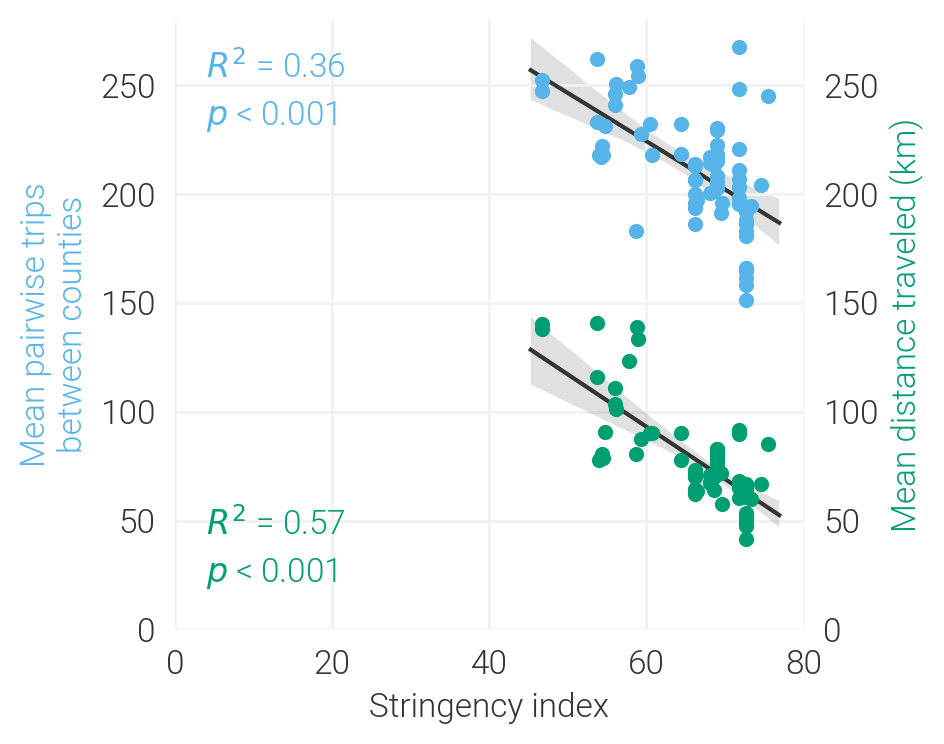

In [90]:
fig, ax = plt.subplots( dpi=200, figsize=(5,4) )
#ax.scatter( x="stringency", y="efficiency", data=test, c="lightgray", s=20, zorder=10 )
ax.scatter( x="stringency", y="efficiency", data=test.loc[test["date"]>"2020-03-15"], c="#56B4E9", s=20, zorder=10 )
sns.regplot( x="stringency", y="efficiency", data=test.loc[test["date"]>"2020-03-15"], color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax, truncate=False )

ax2 = ax.twinx()
ax2.scatter( x="stringency", y="distance", data=test.loc[test["date"]>"2020-03-15"], c="#009E73", s=20, zorder=10 )
sns.regplot( x="stringency", y="distance", data=test.loc[test["date"]>"2020-03-15"], color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax2, truncate=False )

ax.set_xlabel( "Stringency index", fontsize=12 )
ax.set_ylabel( "Mean pairwise trips\nbetween counties", fontsize=12, color="#56B4E9" )
ax2.set_ylabel( "Mean distance traveled (km)", fontsize=12, color="#009E73" )
ax2.set_ylim(0, 280)
[ax2.spines[j].set_visible(False) for j in ax.spines]
ax2.tick_params( axis="y", right=False, which="both", labelsize=12, color="#009E73" )

ax.text( 0.05, 0.95, f"$R^2$ = {result.statistic**2:.2f}", transform=ax.transAxes, fontsize=12, ha="left", va="top", color="#56B4E9" )
ax.text( 0.05, 0.87, f"$p$ < 0.001", transform=ax.transAxes, fontsize=12, ha="left", va="top", color="#56B4E9" )
ax.text( 0.05, 0.2, f"$R^2$ = {distance_result.statistic**2:.2f}", transform=ax.transAxes, fontsize=12, ha="left", va="top", color="#009E73" )
ax.text( 0.05, 0.2-0.08, f"$p$ < 0.001", transform=ax.transAxes, fontsize=12, ha="left", va="top", color="#009E73" )


ax.grid( which="both", axis="both", linewidth=1, color="#F1F1F1", zorder=1)
[ax.spines[j].set_visible(False) for j in ax.spines]
ax.tick_params( axis="x", bottom=False, which="both", labelbottom=True, labelsize=12 )
ax.tick_params( axis="y", left=False, which="both", labelsize=12 )
ax.set_facecolor( "w" )
ax.set_xlim(0, 80)
ax.set_ylim(0, 280)

plt.tight_layout()
plt.show()


We plot the two figures together to aid in lining up panels in the final figure.

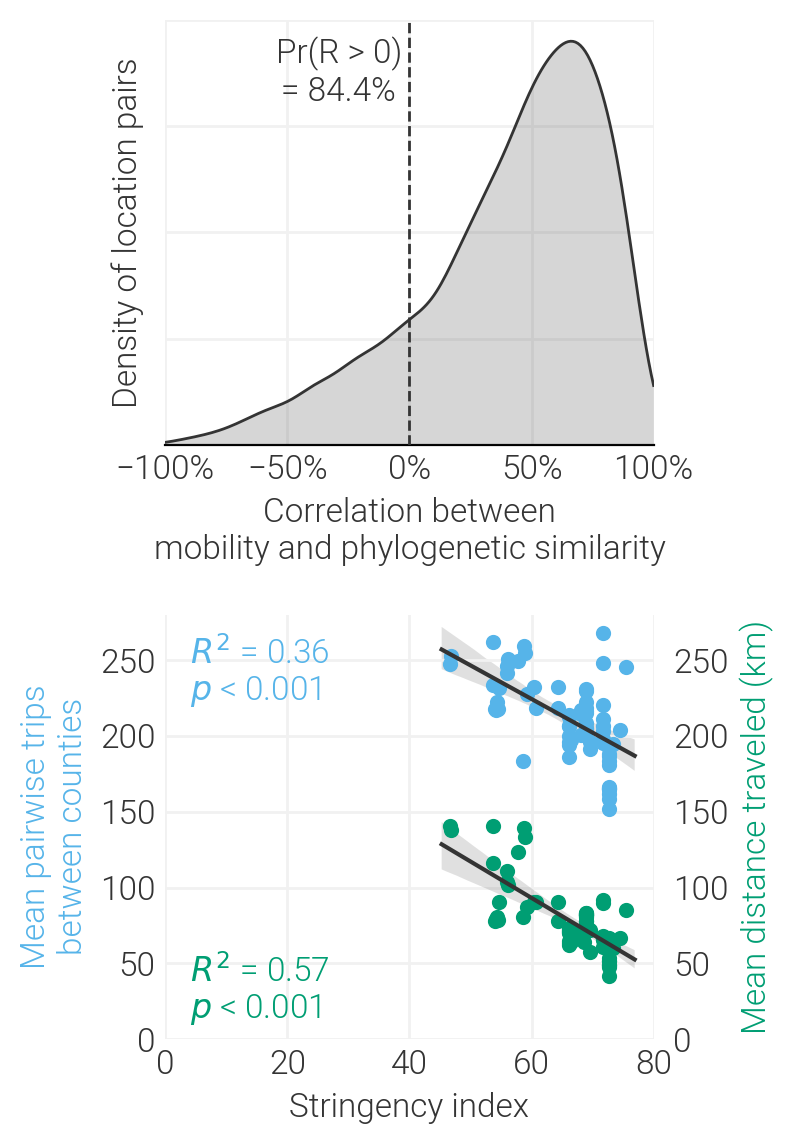

In [103]:
fig, ax = plt.subplots( dpi=200, figsize=(4.25,6), nrows=2 )
ax[0].plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax[0].fill_between(x_grid,[y for y in y_grid], facecolor=COLOR, edgecolor='none', alpha=0.2, zorder=100)

ax[0].axvline( 0, color=COLOR, linestyle="dashed", linewidth=1, zorder=102 )
ax[0].text( -0.29, 0.81, f"Pr(R > 0)\n= {pr_positive:.1%}", fontsize=12, ha="center" )

ax[0].set_ylim( 0 )
basic_formatting( ax[0], which="both", ylabel="Density of location pairs", xlabel="Correlation between\nmobility and phylogenetic similarity", xlims=(-1, 1), ylims=(0,1), xsize=12, ysize=12 )
ax[0].xaxis.set_major_formatter( PercentFormatter(1) )
ax[0].set_yticks( [0,0.25,0.5,0.75,1])
ax[0].set_yticklabels( [] )
ax[0].set_facecolor( "w" )

ax[1].scatter( x="stringency", y="efficiency", data=test.loc[test["date"]>"2020-03-15"], c="#56B4E9", s=20, zorder=2 )
sns.regplot( x="stringency", y="efficiency", data=test.loc[test["date"]>"2020-03-15"], color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax[1], truncate=False )
ax[1].text( 0.05, 0.95, f"$R^2$ = {result.statistic**2:.2f}", transform=ax[1].transAxes, fontsize=12, ha="left", va="top", color="#56B4E9" )
ax[1].text( 0.05, 0.95-0.09, f"$p$ < 0.001", transform=ax[1].transAxes, fontsize=12, ha="left", va="top", color="#56B4E9" )
ax[1].text( 0.05, 0.2, f"$R^2$ = {distance_result.statistic**2:.2f}", transform=ax[1].transAxes, fontsize=12, ha="left", va="top", color="#009E73" )
ax[1].text( 0.05, 0.2-0.09, f"$p$ < 0.001", transform=ax[1].transAxes, fontsize=12, ha="left", va="top", color="#009E73" )


ax2 = ax[1].twinx()
ax2.scatter( x="stringency", y="distance", data=test.loc[test["date"]>"2020-03-15"], c="#009E73", s=20, zorder=2 )
sns.regplot( x="stringency", y="distance", data=test.loc[test["date"]>"2020-03-15"], color=COLOR, scatter=False, line_kws={"zorder" : 5, "linewidth" : 1.5}, ax=ax2, truncate=False )
ax[1].set_ylabel( "Mean pairwise trips\nbetween counties", fontsize=12, color="#56B4E9" )
ax2.set_ylabel( "Mean distance traveled (km)", fontsize=12, color="#009E73" )
ax2.set_ylim(0, 280)
[ax2.spines[j].set_visible(False) for j in ax2.spines]
ax2.tick_params( axis="y", right=False, which="both", labelsize=12, color="#009E73" )

basic_formatting( ax[1], which="both", spines=[], ylabel="Mean pairwise trips\nbetween counties", xlabel="Stringency index", xlims=(0, 80), ylims=(0, 280), xsize=12, ysize=12 )


plt.tight_layout()
fig.savefig( "../analyses/plots/figureX_mobility_phylosor_corr.pdf" )
plt.show()